In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("naive-bayes-imdb/train.csv", index_col=0)
df.head()

,review,label
0,I think they really let the quality of the DVD...,0
1,I'm sorry but this is just awful. I have told ...,0
2,"The Japenese sense of pacing, editing and musi...",0
3,"In the '60's/'70's, David Jason was renowned f...",1
4,"""Hail The Woman"" is one of the most moving fil...",1


In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context



nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

en_stop = list(stopwords.words('english'))
lemmatizer = WordNetLemmatizer() 

def tokenize(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [t for t in tokens if
              re.match(r'[^\W\d]*$', t) and (len(t) > 2) and (t not in en_stop)]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

tokens = df['review'].apply(tokenize)

[nltk_data] Downloading package punkt to /Users/ilya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ilya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ilya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
from itertools import chain
from collections import defaultdict
from gensim.models import Phrases



In [6]:
bigram_transformer = Phrases(tokens)

In [7]:
all_words = set(chain(*bigram_transformer[tokens]))

word_count = defaultdict(lambda: 0)
word_pos_count = defaultdict(lambda: 0)

for sent, label in zip(bigram_transformer[tokens], df.label):
    sent = set(sent)
    for word in sent:
        word_count[word] += 1
        word_pos_count[word] += label

In [8]:
word_prob = {word: word_pos_count[word] / word_count[word] for word in word_count}

In [9]:
word_entropy = {word: -(1 - p) * np.log(1 - p) - p * np.log(p) for word, p in word_prob.items() if 0 < p < 1}
for x in word_prob:
    if word_prob[x] == 0 or word_prob[x] == 1:
        word_entropy[x] = 0

In [10]:
import matplotlib.pyplot as plt

(array([4.6788e+04, 2.0000e+00, 3.0000e+00, 1.2000e+01, 4.1000e+01,
        7.5000e+01, 1.2400e+02, 2.4300e+02, 3.2700e+02, 3.6200e+02,
        1.0090e+03, 9.5200e+02, 3.5100e+02, 1.8280e+03, 2.0850e+03,
        1.3140e+03, 3.9600e+03, 3.3870e+03, 9.0200e+03, 2.3525e+04]),
 array([0.        , 0.03465736, 0.06931472, 0.10397208, 0.13862944,
        0.1732868 , 0.20794415, 0.24260151, 0.27725887, 0.31191623,
        0.34657359, 0.38123095, 0.41588831, 0.45054567, 0.48520303,
        0.51986039, 0.55451774, 0.5891751 , 0.62383246, 0.65848982,
        0.69314718]),
 <a list of 20 Patch objects>)

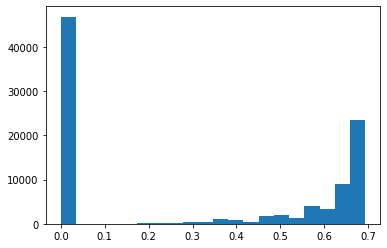

In [11]:
plt.hist(word_entropy.values(), bins=20)

In [12]:
from gensim.models import Word2Vec

model = Word2Vec(bigram_transformer[tokens], sg=1, size=200, window=4, min_count=5, iter=20)

In [28]:
def encode3(list_of_tokens):
    x = np.array([model.wv[t] * (.7 - word_entropy[t]) for t in list_of_tokens if ((t in model.wv.vocab) and (t in word_entropy))])
    if x.size == 0:
        return np.zeros((model.wv['film'].size * 1))
    return np.hstack((np.mean(x, axis=0), np.min(x, axis=0), np.max(x, axis=0)))

    
fts = np.array([encode3(t) for t in bigram_transformer[tokens]])
fts.shape

(40000, 600)

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(fts, df.label.values,
                                                    test_size=0.2, shuffle=True)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=2000, C=1000, verbose=1, n_jobs=4).fit(X_train[:, :], y_train)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
from sklearn.metrics import classification_report

predicts = clf.predict((X_train)).round()
print('Train\n', classification_report(y_train, predicts, digits=5))

predicts = clf.predict((X_test)).round()
print('Test\n', classification_report(y_test, predicts, digits=5))

In [17]:
clf = LogisticRegression(max_iter=2000, C=50, verbose=1, n_jobs=4).fit(fts, df.label.values)

test = pd.read_csv('naive-bayes-imdb/test.csv', index_col=0)
test_tokens = test['review'].apply(tokenize)
test_fts = np.array([encode3(t) for t in bigram_transformer[test_tokens]])

predicted = clf.predict(test_fts)

pd.DataFrame({'Predicted': predicted}).to_csv('solution.csv', index_label='Id')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.3s finished


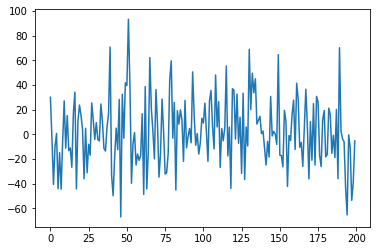

In [27]:
import matplotlib.pyplot as plt
plt.plot(clf.coef_[0])